# **Practica 2.b: Técnicas de búsqueda basadas en poblaciones para el Problema del Aprendizaje de Pesos en Características**
## *Pablo Millan Cubero*


El problema del aprendizaje de pesos en características parte del aprendizaje supervisado, donde tenemos un conjunto de datos en los que para cada elemento se tienen N características por cada individuo y la clase a la que este pertenece.<br>
<br>\begin{align}
        C_n = (x_1, w_2, ..., x_n)
    \end{align}
<br>Nuestro objetivo es predecir la clase de nuevos individuos fuera del conjunto a partir de sus características. Esto lo hacemos en dos fases: aprendizaje, donde extraemos información de un conjunto de datos para aprender de él y validación, donde comprobamos cómo de bien funciona nuestro modelo para datos nuevos

<br>En nuestro caso usaremos el *clasificador 1-NN*. Partimos de un dataset del que disponemos de las clases. Si tenemos un elemento nuevo E al que queremos obtener su clase, calculamos la distancia euclidea de E al resto de elementos y le asignamos la clase del vecino con menor distancia.

<br>El Aprendizaje de Pesos en Características (APC) es un problema que optimiza el rendimiento de 1-NN ponderando la importancia de cada atributo a la hora de calcular la distancia. Para ello usamos un vector w:<br>

<br>\begin{align}
        w = (w_1, w_2, ..., w_n), w_i\in[0, 1]
    \end{align}

<br>Nuestro objetivo será encontrar los valores para cada $w_i$ que nos proporcionen un mejor resultado.

A continuación se ejecutan los imports para las librerías que se van utilizar a lo largo de la práctica.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import KFold
from google.colab import drive
drive.mount('/content/drive')
import time
from scipy.io import arff
import random
from numba import jit

Mounted at /content/drive


A continuación se introduce una celda con las funciones auxiliares que rescatamos de la práctica anterior. No se incluye el pseudocódigo de estas porque se considera redundante, ya que como digo, son exactamente las mismas versiones que se presentaron anteriormente.

In [ ]:
def cargar_datos(nombre):

  data = arff.loadarff(nombre)
  datos = np.zeros((len(data[0]), len(data[0][0])-1))

  #Cargamos datos
  for i in range(0, len(datos)):
    for j in range(0, len(datos[0])):
      datos[i][j] = data[0][i][j]

  #Cargamos los atributos
  clases = np.chararray(len(datos))
  n_atrib = len(datos[0])
  for i in range (0, len(datos)):
    clases[i] = data[0][i][n_atrib]

  return datos, clases

#Calcula el minimo y maximo para cada atributo de un conjunto de datos
def max_min_values(datos):
  max = np.zeros(len(datos[0]))
  min = np.zeros(len(datos[0]))

  min = np.apply_along_axis(np.amin, 0, datos)
  max = np.apply_along_axis(np.amax, 0, datos)

  return min, max

#Normaliza un set de datos dado el vector de minimos y el vector max-min
def normaliza(datos, min, dif):
  ret = (datos - min)/dif
  ret[np.isnan(ret)] = 0
  return ret

#Similar a la función anterior pero devuelve el vector distancias
def dist_1NN(nuevo, datos, w):
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  return distancias

#Devuelve la predicción de clase del ejemplo 'nuevo'
def classf_1NN(nuevo, datos, w):
  t1 = time.time()
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  #return np.where(distancias == np.amin(distancias))[0][0]
  s = np.argmin(distancias)
  t2 = time.time()
  return s

#Devuelve la predicción de clase del ejemplo 'nuevo', version alternativa
@jit(nopython=True)
def classf_1NN_(nuevo, datos, w, i):
  distancias = np.sum((datos-nuevo)**2*w, 1)**0.5
  distancias[i] = np.Inf
  #return np.where(distancias == np.amin(distancias))[0][0]
  return np.argmin(distancias)

#Ejecuta el classificador 1-NN para un ejemplo de datos y de test
  #devuelve el indice del más cercano a cada uno
def alg_1NN(datos, test, w, max_values, min_values):

  dif = max_values - min_values
  test = (test - min_values)/dif
  datos = normaliza(datos, min_values, dif)

  index_clases = np.zeros(len(test))
  for i in range(0, len(test)):
    index_clases[i] = classf_1NN(test[i], datos, w)

  return index_clases

#Calcular error para un conjunto de train y test
def calcular_error(datos, clas_d, test, clas_t, w):
  error = 0.0
  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  min_val, max_val = max_min_values(test)
  test = normaliza(test, min_val, max_val-min_val)

  for i in range(0, len(test)):
    c = classf_1NN(test[i], datos, w)
    if (clas_d[c] == clas_t[i]):
      error += 1

  return error/len(test)

#Calcula el error sobre un conjunto (leave one out)
@jit(nopython=True)
def calcular_error_leave(datos, clases, w):

  w_temp = w.copy()
  w_temp[w_temp < 0.1] = 0

  aciertos = 0
  for i in range(0, len(datos)):
    c = classf_1NN_(datos[i], datos, w_temp, i)
    if (clases[c] == clases[i]):
      aciertos += 1

  return aciertos/len(datos)

@jit(nopython=True)
def evaluacion(datos, clases, w, alpha):
  error = calcular_error_leave(datos, clases, w)
  return alpha*error + (1 - alpha)*( len(w[w < 0.1])/len(w) )

Como se comentó en la práctica anterior, la función de evaluación presenta la siguiente forma:<br>

<br>\begin{align}
        tasa\_clas = 100⋅\frac{nº\: instancias\: bien\: clasificadas}{nº\: instancias}
    \end{align}

<br>\begin{align}
        tasa\_red = 100⋅\frac{nº\: valores\: w_i < 0.1}{nº\: caracteristicas}
    \end{align}

Tendremos la siguiente función de evaluación:

<br>\begin{align}
        F(W) = \alpha⋅tasa\_clas(W)+(1-\alpha)⋅tasa\_red(W)
    \end{align}

In [ ]:
def evaluacion_detallada(datos, clases, w, alpha):
  error = calcular_error_leave(datos, clases, w)
  return alpha*error + (1 - alpha)*( len(w[w < 0.1])/len(w) ), error, ( len(w[w < 0.1])/len(w) )

A continuación se presentan los operadores de cruce que se van a emplear para obtener los hijos de 2 cromosomas. Tienen como entrada los dos padres, y como salida devuelven 2 pesos, correspondientes a los dos hijos posibles de esta pareja. Esto se hizo así por simplificación y optimización, ya que en todo momento sacaremos 2 hijos de una pareja.

Pseudocódigo de cruce_BLX:
```
cruce_BLX(c1, c2):

  cmin = min(c1, c2)
  cmax = max(c1, c2)
  l = cmax-cmin

  salida1 = random_intervalo(cmin-l*0.3, cmax+l*0.3)
  salida2 = random_intervalo(cmin-l*0.3, cmax+l*0.3)

  if (salida1[i] < 0)
    salida1[i] == 0
  if (salida2[i] < 0)
    salida2[i] == 0
  if (salida1[i] > 1)
    salida1[i] == 0
  if (salida2[i] > 1)
    salida2[i] == 0

    return salida

```

Pseudocódigo del cruce_aritmético:
```
cruce_aritmetico(c1, c2):
  alpha = vector_random([0, 1])
  salida1 = c1*alpha + c2*1-alhpa # operacion vectorial
  salida2 = c1*(1-alpha) + c2*alpha #operacion vectorial

  return salida1, salida2
```

In [ ]:
@jit(nopython=True)
def cruce_BLX(c1, c2):

  salida1 = np.zeros(len(c1)+1)
  salida2 = np.zeros(len(c1)+1)

  for i in range(0,len(c1)):

    if (c1[i] < c2[i]):
      cmin = c1[i]
      cmax = c2[i]
    else:
      cmin = c2[i]
      cmax = c1[i]

    l = cmax-cmin

    b1 = cmin-l*0.3
    if (b1 < 0):
      b1 = 0
    b2 = cmax+l*0.3
    if (b2 > 1):
      b2 = 1

    salida1[i] = np.random.uniform(b1, b2)
    salida2[i] = np.random.uniform(b1, b2)

  return salida1, salida2

@jit(nopython=True)
def cruce_aritmetico(c1, c2):

  alpha = np.random.rand(1)[0]
  salida1 = np.zeros(len(c1)+1)
  salida2 = np.zeros(len(c1)+1)

  salida1[0:len(c1)] = c1*alpha + c2*(1-alpha)
  salida2[0:len(c1)] = c1*(1-alpha) + c2*alpha

  return salida1, salida2

El operador de mutación es idéntico a su versión de la práctica anterior para la búsqueda local. Se genera un incremento en base a una distribución normal y se controla que el valor final se encuentre dentro del intervalo [0, 1]. El pseudocódigo es el que sigue:
```
mutar(w):
  w[i] = N(0, 0.3)
  Si w[i] < 0 -> 0
  Si [wi] > 1 -> 1
```
Para la generación de soluciones aleatorias con las que arrancamos las búsquedas, el código está integrado en las búsquedas en lugar de en una solución a parte. No considero que haga falta expresarlo como pseudocódigo ya que sería de una sola linea. Basta con saber que se genera un array de pesos en el que cada elemento se genera con una distribución aleatoria uniforme entre el intervalo [0, 1].

In [ ]:
# Muta el gen (i, j) de la población
def mutar(i, j, poblacion):

  poblacion[i][j] += np.random.normal(0, 0.3)
  if (poblacion[i][j] < 0):
    poblacion[i][j] = 0
  if (poblacion[i][j] > 1):
    poblacion[i][j] = 1

Para los algoritmos generacionales seguimos dos esquemas de selección:



*   AGG: De forma iterativa seleccionamos 2 individuos aleatorios de la población. Los enfrentamos en un torneo, y el mejor de los 2 (que tenga mayor fitness). El seleccionado formará a pasar parte del conjunto de padres. Se escoge siempre el mismo número de padres, que corresponde a multiplicar el tamaño de la población por la probabilidad de cruce. Así ahorramos generar un número aleatorio por cada individuo.
```
for i in tamaño_poblacion*probabilidad_cruce:
    c1 = seleccion_aleatoria(poblacion)
    c2 = seleccion_aleatoria(poblacion)

    c = torneo2(c1, c2)

    padres.add(c)
```
*   AGE: Se seleccionan 4 cromosomas de forma aleatoria, se emparejan de 2 en 2, y se selecciona el mejor de cada pareja. Esos serán los padres de esta generación.
```
  c1 = seleccion_aleatoria(poblacion)
  c2 = seleccion_aleatoria(poblacion)
  c3 = seleccion_aleatoria(poblacion)
  c4 = seleccion_aleatoria(poblacion)

  padre1, padre2 = torneo4(c1, c2, c3, c4)
```



Se muestra ahora el código de torneo2 y torneo4. Como se puede comprobar simplemente seleccionan el mejor entre parejas, por lo que no se considera necesario especificar el pseudocódigo. Son dos funciones con responsabilidades identicas, se han separado en 2 por razones de optimización.

In [ ]:
# Recibe 4 individuos y selecciona 2 por torneo
def torneo4(seleccion):
  if (seleccion[0][-1] > seleccion[1][-1]):
    c1 = seleccion[0]
  else:
    c1 = seleccion[1]

  if (seleccion[2][-1] > seleccion[3][-1]):
    c2 = seleccion[2]
  else:
    c2 = seleccion[3]

  return c1[0:-1], c2[0:-1]

# Recibe 2 individuos y selecciona el mejor por torneo
def torneo2(seleccion, poblacion):

  c1 = poblacion[seleccion[0]]
  c2 = poblacion[seleccion[1]]

  if (c1[-1] > c2[-1]):
    s = seleccion[0]
  else:
    s = s = seleccion[1]

  return s

## Algoritmo Genético Estacionario (AGE)

La población está representada en todos los algoritmos como una matriz, en la que cada fila corresponde con el vector de pesos $w$ y representan un cromosoma. Además, se añade en cada fila un elemento extra que corresponde con la evaluación de fitness.

<br>El esquema de evolución y reemplazamiento considerados para este algoritmo son los siguientes:

1.   Se parte de una POBLACIÓN.
2.   Se seleccionan 4 elementos de POBLACIÓN.
3.   Se emparejan los elementos tal que [1, 2] y [3, 4] y se escoge el mejor de cada pareja para ser PADRE1 y PADRE2.
4.   Se cruzan PADRE1 y PADRE2 para obtener HIJO1 e HIJO2.
5.   Se realizan el número de mutaciones pertinentes a HIJO1 e HIJO2 y se evaluan.
6.   Los hijos compiten por entrar en POBLACIÓN. Es decir, si son mejores que uno de los dos peores, entrarán.
7.   Volvemos al punto 1.

El pseudocódigo es el siguiente:
```
def estacionario(datos, label, cruce, tam_pob, iteraciones_max, prob_mut):
  poblacion = generar_aleatorio(tam_poblacion)

  evaluaciones = 0

  while (evaluaciones < iteraciones_max):

    # Hacemos la seleccion
    seleccion = selecciona_4_random(poblacion)
    c1, c2 = torneo4(seleccion)

    # Cruzamos los padres
    hijo1, hijo2 = cruce(c1, c2)

    # Mutamos los hijos y realizamos las evaluaciones
    hijo1, hijo2 = aplicar_mutaciones(tamaño_w*2*prob_mut, hijo1, hijo2)
    hijo1.evaluar()
    hijo2.evaluar()

    # Los hijos compiten por entrar en la poblacion

    if (hijo mejor que los dos peores):
      poblacion.elimina_peor()
      poblacion.add(hijo1 y/ó hijo2)

    evaluaciones += 2
```
A continuación la implementación:

In [ ]:
def estacionario(datos, label, cruce, tam_pob, iteraciones_max, prob_mut):
  
  tam_w = len(datos[0])
  n_genes = tam_pob * tam_w
  
  #Creo aleatoriamente la poblacion inicial
  poblacion = np.zeros((tam_pob, len(datos[0])+1))
  for i in range(0, tam_pob):
    w = np.random.rand(len(datos[0]))
    poblacion[i][0:len(datos[0])] = w
    poblacion[i][len(datos[0])] = evaluacion(datos, label, w, 0.5)

  # Ordenamos en función a su función de evaluación
  poblacion = np.array(poblacion)
  poblacion = poblacion[poblacion[:, -1].argsort()]

  iterations = 0
  while (iterations < iteraciones_max):

    # Seleccionamos 4 individuos y elegimos 2 por torneo
    seleccion = poblacion[random.sample(range(tam_pob), 4)]
    c1, c2 = torneo4(seleccion)

    # Hacemos 2 cruces
    seleccion = np.zeros((4, len(datos[0])+1))
    h1, h2 = cruce(c1, c2)

    # Aplicamos las mutaciones
    mutaciones = [random.sample(range(tam_w*2), (int)(2*tam_w*prob_mut))]
    for i in range(0, len(mutaciones)):
      r = np.random.randint(tam_w*2)
      i = r // tam_w
      j = r % tam_w
      mutar(i, j, [h1, h2])
    
    h1[len(h1)-1] = evaluacion(datos, label, h1[0:len(h1)-1], 0.5)
    h2[len(h2)-1] = evaluacion(datos, label, h1[0:len(h2)-1], 0.5)

    # Los hijos compiten para entrar en la poblacion
    seleccion[0] = h1
    seleccion[1] = h2
    seleccion[2] = poblacion[0]
    seleccion[3] = poblacion[1]
    seleccion = seleccion[seleccion[:, -1].argsort()]
    poblacion[0] = seleccion[len(seleccion)-1]
    poblacion[1] = seleccion[len(seleccion)-2]

    # Ordenamos la poblacion
    poblacion = poblacion[poblacion[:, -1].argsort()]

    iterations += 2

  return poblacion[-1][0:len(datos[0])], poblacion[-1][tam_w]

## Algoritmo Genético Generacional (AGG)

El esquema de evolución y reemplazamiento del algoritmo generacional:

1.   Se parte de una POBLACIÓN.
2.   Se seleccionan $tamañoPoblacion$ parejas de elementos de POBLACIÓN.
3.   De cada pareja se realiza un torneo y se escoge la mejor en cuanto a fitness. Ese se añade a SELECCION.
4.   Se escogen los $tamañoPoblacion*probabilidadCruce$ primeros elementos de SELECCION para ser PADRES. Los elementos restantes se añaden a NUEVA_GENERACION
5.   Se cruzan los elementos de PADRES siguiendo el orden (PADRES[0], PADRES[1]), (PADRES[02], PADRES[3]), etc. Los hijos se añaden a NUEVA_GENERACION
6.   Se realizan $tamañoPoblacion*probabilidadMutacion$ mutaciones a NUEVA_GENERACION y se evaluan los elementos que no se han evaluado. Si el mejor elemento de la generación pasada es mejor que el peor de la nueva, se sustituye por el peor de la nueva.
7.   Volvemos al punto 1.

El pseudocódigo:

```
def generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
  poblacion = generar_aleatorio(tam_poblacion)

  evaluaciones = 0
  while (evaluaciones < iteraciones_max):

    # Hacemos la seleccion
    for i in tam_pob:
      pareja = escoger_pareja(poblacion)
      c = torneo2(pareja)
      seleccion.add(c)

    # Escogemos los padres
    padres = seleccion.get(tam_pob*prob_cruce)
    nueva_generacion = seleccion - padres

    # Cruzamos los padres
    for pareja in padres:
      h1, h2 = cruce(pareja)
      nueva_generacion.add(h1, h2)

    # Mutamos los hijos
    for i in tam_poblacion*prob_mut:
      c = get_random(nueva_generacion)
      c.mutar_gen_aleatorio()

    # Realizamos las evaluaciones
    for i in evaluaciones_realizadas
      nueva_generacion.evaluar_elemento()

    # El mejor de la generación pasada compite por entrar
    if (mejor_anterior_generacion > peor_nueva_generacion):
      nueva_generacion[peor] = mejor

    poblacion = nueva_generacion

    evaluaciones += evaluaciones_realizadas
```

Y a continuación el código:

In [ ]:

def generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):

  tam_w = len(datos[0])
  n_genes = tam_pob * tam_w
  
  #Creo aleatoriamente la poblacion inicial
  poblacion = np.zeros((tam_pob, len(datos[0])+1))
  for i in range(0, tam_pob):
    w = np.random.rand(len(datos[0]))
    poblacion[i][0:len(datos[0])] = w
    poblacion[i][len(datos[0])] = evaluacion(datos, label, w, 0.5)
  
  iterations = 0
  while (iterations < iteraciones_max):

    mejor_individuo = poblacion[np.argmax(poblacion[:, -1])]

    # Seleccionamos 4 individuos y elegimos 2 por torneo
    seleccion = np.zeros(tam_pob, dtype=np.intc)
    for i in range(0, tam_pob):
      r1 = np.random.randint(tam_pob)
      r2 = np.random.randint(tam_pob)
      seleccion[i] = torneo2([r1, r2], poblacion)

    # Separamos la seleccion en la sección que cruzamos y la que no
    cruzar = poblacion[seleccion[0:(int)(tam_pob*prob_cruce)+1]]
    #cruzar = np.delete(cruzar, -1, 1)
    no_cruce = poblacion[seleccion[(int)(tam_pob*prob_cruce)+1:tam_pob]]

    # Realizamos los cruces y creamos la nueva generacion

    nueva_generacion = np.zeros((len(cruzar), tam_w+1))
    for i in range(0, len(cruzar)//2):
        a, b = cruce(cruzar[i][0:tam_w], cruzar[i+len(cruzar)//2][0:tam_w])
        nueva_generacion[i] = a
        nueva_generacion[i+len(cruzar)//2] = b
    nueva_generacion = np.concatenate((nueva_generacion, no_cruce), axis=0)

    # Aplicamos las mutaciones
    evaluar = np.arange((int)(tam_pob*prob_cruce)+1)
    evaluar_mut = []
    for n in range(0, (int)(tam_pob*prob_mut)):
      r = np.random.randint(n_genes)
      i = r // tam_w
      j = r % tam_w
      mutar(i, j, nueva_generacion)
      if (i >= (int)(tam_pob*prob_cruce)+1):
        evaluar_mut.append(i)
    evaluar_mut = np.unique(evaluar_mut)
    
    #Calculamos el fitness
    for i in range(0, len(evaluar)):
      w = nueva_generacion[evaluar[i]]
      w[len(w)-1] = evaluacion(datos, label, w[0:len(w)-1], 0.5)
    for i in range(0, len(evaluar_mut)):
      w = nueva_generacion[evaluar_mut[i]]
      w[len(w)-1] = evaluacion(datos, label, w[0:len(w)-1], 0.5)

    # Si el mejor de la generación pasada es mejor que el peor de la nueva,
    # lo sustituimos
    peor_individuo = np.argmin(poblacion[:, -1])
    if (mejor_individuo[-1] > nueva_generacion[peor_individuo][-1]):
      nueva_generacion[peor_individuo] = mejor_individuo

    poblacion = nueva_generacion

    iterations += len(evaluar)+len(evaluar_mut)

  return poblacion[np.argmax(poblacion[:, -1])][0:tam_w], poblacion[np.argmax(poblacion[:, -1])][tam_w]

## Algoritmo Memético

El algoritmo memético sigue el esquema básico del genético, con una pequeña diferencia: Cada 10 generaciones, se aplica una búsqueda local a algunos de los elementos de la población.<br>

La búsqueda local es idéntica a la implementada en la práctica 1, con la diferencia de que el w de pesos inicial en vez de generarse aleatoriamente se pasa como argumento. Aquí el pseudocódigo:

```
BL_search(datos, iteraciones_maximas, w_inicial)

w_mejor = w_inicial
w = w_mejor
fitness_mejor = 0
iteraciones = 0
contador_vecinos = 0

while (contador_vecinos < w.size()*20 and iteraciones < iteraciones_maximas)

  aciertos = calcular_error(datos, w)
  fitness = evaluacion(w, aciertos)

  if(fitness < fitness_mejor):
    fitness_mejor = fitness
    w_mejor = w
    contador_vecinos = 0
  else:
    contador_vecinos++

  w = operador_mutacion(w9
  iteraciones++

return w_mejor, fitness
```

Y de nuevo la implementación junto al operador de mutación, descrito anteriormente:

In [ ]:
#Obtener vecino de w
def operador_mutacion(w, i):
  w_nuevo = w
  w_nuevo[i] += np.random.normal(0, 0.3)
  if (w_nuevo[i] < 0):
    w_nuevo[i] = 0
  if (w_nuevo[i] > 1):
    w_nuevo[i] = 1

  return w_nuevo

def BL_search(datos, clases, w_ini):

  #Normalizar e inicializar w
  w_mejor = w_ini.copy()
  w = w_mejor.copy()

  contador_greedy = 0
  i_w = 0
  iterations = 0
  fitness_actual = 0.0
  indx_w = np.arange(0, len(w))
  np.random.shuffle(indx_w)

  while(contador_greedy < len(w)*2):

    #Se calcula el fitness para w
    #aciertos = calcular_error_leave(datos, clases, w)
    fitness = evaluacion(datos, clases, w, 0.5)

    #Actualizar fitness y w si procede
    if (fitness > fitness_actual):
      fitness_actual = fitness
      w_mejor = w
      contador_greedy = 0
      i_w = 0
      np.random.shuffle(indx_w)
    else:
      contador_greedy += 1

    #Se calcula nuevo w + control de indices
    w = operador_mutacion(w, indx_w[i_w])
    iterations += 1
    i_w = (i_w+1)%len(w)

  return w, fitness_actual

Y finalmente el pseudocódigo e implementación del algoritmo memético.

```
def memetico(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut, numero_BL, escoger_mejores):
  poblacion = generar_aleatorio(tam_poblacion)

  evaluaciones = 0
  while (evaluaciones < iteraciones_max):

    if (generacion % 10 == 0):
      if (escoger_mejores):
        poblacion.ordena()
      else:
        poblacion.shuffle()

      for i in numero_BL
        poblacion[i] = BL_search(poblacion[i])

    # Hacemos la seleccion
    for i in tam_pob:
      pareja = escoger_pareja(poblacion)
      c = torneo2(pareja)
      seleccion.add(c)

    # Escogemos los padres
    padres = seleccion.get(tam_pob*prob_cruce)
    nueva_generacion = seleccion - padres

    # Cruzamos los padres
    for pareja in padres:
      h1, h2 = cruce(pareja)
      nueva_generacion.add(h1, h2)

    # Mutamos los hijos
    for i in tam_poblacion*prob_mut:
      c = get_random(nueva_generacion)
      c.mutar_gen_aleatorio()

    # Realizamos las evaluaciones
    for i in evaluaciones_realizadas
      nueva_generacion.evaluar_elemento()

    # El mejor de la generación pasada compite por entrar
    if (mejor_anterior_generacion > peor_nueva_generacion):
      nueva_generacion[peor] = mejor

    poblacion = nueva_generacion

    evaluaciones += evaluaciones_realizadas
```

In [ ]:
def memeticos(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut, n_bl, bl_mejores=False):

  tam_w = len(datos[0])
  n_genes = tam_pob * tam_w
  
  #Creo aleatoriamente la poblacion inicial
  poblacion = np.zeros((tam_pob, len(datos[0])+1))
  for i in range(0, tam_pob):
    w = np.random.rand(len(datos[0]))
    poblacion[i][0:len(datos[0])] = w
    poblacion[i][len(datos[0])] = evaluacion(datos, label, w, 0.5)
  
  iterations = 0
  meme_count = 0
  while (iterations < iteraciones_max):

    # Cada 10 generaciones hacemos BL 
    if (meme_count == 10):
      meme_count = 0

      # Si se cogen los N mejores, ordenamos la población
      if (bl_mejores):
        poblacion = poblacion[poblacion[:, -1].argsort()]
      # Si no, se hace seleccion aleatoria
      else:
        np.random.shuffle(poblacion)
        
      # Aplicamos BL
      for i in range(0,(int)(n_bl*tam_pob)):
        w, fitness = BL_search(datos, label, poblacion[i][0:tam_w])
        poblacion[i][0:tam_w] = w
        poblacion[i][tam_w] = fitness

    mejor_individuo = poblacion[np.argmax(poblacion[:, -1])]

    # Seleccionamos 4 individuos y elegimos 2 por torneo
    seleccion = np.zeros(tam_pob, dtype=np.intc)
    for i in range(0, tam_pob):
      r1 = np.random.randint(tam_pob)
      r2 = np.random.randint(tam_pob)
      seleccion[i] = torneo2([r1, r2], poblacion)

    # Separamos la seleccion en la sección que cruzamos y la que no
    cruzar = poblacion[seleccion[0:(int)(tam_pob*prob_cruce)+1]]
    #cruzar = np.delete(cruzar, -1, 1)
    no_cruce = poblacion[seleccion[(int)(tam_pob*prob_cruce)+1:tam_pob]]

    # Realizamos los cruces y creamos la nueva generacion

    nueva_generacion = np.zeros((len(cruzar), tam_w+1))
    for i in range(0, len(cruzar)//2):
        a, b = cruce(cruzar[i][0:tam_w], cruzar[i+len(cruzar)//2][0:tam_w])
        nueva_generacion[i] = a
        nueva_generacion[i+len(cruzar)//2] = b
    nueva_generacion = np.concatenate((nueva_generacion, no_cruce), axis=0)

    # Aplicamos las mutaciones
    evaluar = np.arange((int)(tam_pob*prob_cruce)+1)
    evaluar_mut = []
    for n in range(0, (int)(tam_pob*prob_mut)):
      r = np.random.randint(n_genes)
      i = r // tam_w
      j = r % tam_w
      mutar(i, j, nueva_generacion)
      if (i >= (int)(tam_pob*prob_cruce)+1):
        evaluar_mut.append(i)
    evaluar_mut = np.unique(evaluar_mut)
    
    #Calculamos el fitness
    for i in range(0, len(evaluar)):
      w = nueva_generacion[evaluar[i]]
      w[len(w)-1] = evaluacion(datos, label, w[0:len(w)-1], 0.5)
    for i in range(0, len(evaluar_mut)):
      w = nueva_generacion[evaluar_mut[i]]
      w[len(w)-1] = evaluacion(datos, label, w[0:len(w)-1], 0.5)

    # Si el mejor de la generación pasada es mejor que el peor de la nueva,
    # lo sustituimos
    peor_individuo = np.argmin(poblacion[:, -1])
    if (mejor_individuo[-1] > nueva_generacion[peor_individuo][-1]):
      nueva_generacion[peor_individuo] = mejor_individuo

    poblacion = nueva_generacion

    iterations += len(evaluar) + len(evaluar_mut) + (int)(n_bl*tam_pob)

  return poblacion[np.argmax(poblacion[:, -1])][0:tam_w], poblacion[np.argmax(poblacion[:, -1])][tam_w]

## Ejecuciones

In [ ]:
def cross_validation_generacional(datos, clases, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    # generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
    w, error = generacional(datos[train_index], clases[train_index], cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_estacionario(datos, clases, cruce, tam_pob, iteraciones_max, prob_mut):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    # generacional(datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut):
    w, error = estacionario(datos[train_index], clases[train_index], cruce, tam_pob, iteraciones_max, prob_mut)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_memetico(datos, clases, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut, n_bl, bl_mejores):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    #                   (datos, label, cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut, n_bl, bl_mejores=False)
    w, error = memeticos(datos[train_index], clases[train_index], cruce, tam_pob, iteraciones_max, prob_cruce, prob_mut, n_bl, bl_mejores)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO ARITMETICO ++++++++++++ IONOSPHERE")
print(cross_validation_generacional(datos, clases, cruce_aritmetico, 30, 15000, 0.7, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO ARITMETICO ++++++++++++ PARKINSONS")
print(cross_validation_generacional(datos, clases, cruce_aritmetico, 30, 15000, 0.7, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO ARITMETICO ++++++++++++ SPECTF-HEART")
print(cross_validation_generacional(datos, clases, cruce_aritmetico, 30, 15000, 0.7, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO BLX ++++++++++++ IONOSPHERE")
print(cross_validation_generacional(datos, clases, cruce_BLX, 30, 15000, 0.7, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO BLX ++++++++++++ PARKINSONS")
print(cross_validation_generacional(datos, clases, cruce_BLX, 30, 15000, 0.7, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("GENETICO BLX ++++++++++++ SPECTF-HEART")
print(cross_validation_generacional(datos, clases, cruce_BLX, 30, 15000, 0.7, 0.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


GENETICO ARITMETICO ++++++++++++ IONOSPHERE
Fitness en training:  0.889
Aciertos test:  0.831  Red en test:  0.824  Fitness test:  0.8274999999999999
T:  120.53705430030823
---------------
Fitness en training:  0.806
Aciertos test:  0.814  Red en test:  0.676  Fitness test:  0.745
T:  120.24345302581787
---------------
Fitness en training:  0.894
Aciertos test:  0.829  Red en test:  0.853  Fitness test:  0.841
T:  119.34011149406433
---------------
Fitness en training:  0.865
Aciertos test:  0.914  Red en test:  0.794  Fitness test:  0.8540000000000001
T:  119.64471459388733
---------------
Fitness en training:  0.886
Aciertos test:  0.886  Red en test:  0.853  Fitness test:  0.8694999999999999
T:  119.67090582847595
---------------
None
GENETICO ARITMETICO ++++++++++++ PARKINSONS
Fitness en training:  0.877
Aciertos test:  0.769  Red en test:  0.864  Fitness test:  0.8165
T:  27.02483606338501
---------------
Fitness en training:  0.909
Aciertos test:  0.769  Red en test:  0.864  Fitn

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO ARITMETICO ++++++++++++ IONOSPHERE")
print(cross_validation_estacionario(datos, clases, cruce_aritmetico, 30, 15000, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO ARITMETICO ++++++++++++ PARKINSONS")
print(cross_validation_estacionario(datos, clases, cruce_aritmetico, 30, 15000, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO ARITMETICO ++++++++++++ SPECTF-HEART")
print(cross_validation_estacionario(datos, clases, cruce_aritmetico, 30, 15000, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO BLX ++++++++++++ IONOSPHERE")
print(cross_validation_estacionario(datos, clases, cruce_BLX, 30, 15000, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO BLX ++++++++++++ PARKINSONS")
print(cross_validation_estacionario(datos, clases, cruce_BLX, 30, 15000, 0.1))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("ESTACIONARIO BLX ++++++++++++ SPECTF-HEART")
print(cross_validation_estacionario(datos, clases, cruce_BLX, 30, 15000, 0.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


ESTACIONARIO ARITMETICO ++++++++++++ IONOSPHERE
Fitness en training:  0.905
Aciertos test:  0.845  Red en test:  0.853  Fitness test:  0.849
T:  120.40169620513916
---------------
Fitness en training:  0.9
Aciertos test:  0.743  Red en test:  0.882  Fitness test:  0.8125
T:  120.80940771102905
---------------
Fitness en training:  0.888
Aciertos test:  0.743  Red en test:  0.882  Fitness test:  0.8125
T:  120.84094452857971
---------------
Fitness en training:  0.884
Aciertos test:  0.957  Red en test:  0.853  Fitness test:  0.905
T:  120.83769059181213
---------------
Fitness en training:  0.893
Aciertos test:  0.843  Red en test:  0.882  Fitness test:  0.8625
T:  120.64756846427917
---------------
None
ESTACIONARIO ARITMETICO ++++++++++++ PARKINSONS
Fitness en training:  0.883
Aciertos test:  0.821  Red en test:  0.818  Fitness test:  0.8194999999999999
T:  27.505069732666016
---------------
Fitness en training:  0.877
Aciertos test:  0.795  Red en test:  0.818  Fitness test:  0.8065

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 1, False))



datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, False))



datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, True))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, True))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 0.1, True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


MEMETICO AM(10, 1) ++++++++++++ IONOSPHERE
Fitness en training:  0.827
Aciertos test:  0.845  Red en test:  0.735  Fitness test:  0.79
T:  53.41587448120117
---------------
Fitness en training:  0.847
Aciertos test:  0.714  Red en test:  0.794  Fitness test:  0.754
T:  53.80740761756897
---------------
Fitness en training:  0.816
Aciertos test:  0.814  Red en test:  0.706  Fitness test:  0.76
T:  53.914544105529785
---------------
Fitness en training:  0.851
Aciertos test:  0.9  Red en test:  0.794  Fitness test:  0.847
T:  53.849247217178345
---------------
Fitness en training:  0.847
Aciertos test:  0.0  Red en test:  0.794  Fitness test:  0.397
T:  53.79926109313965
---------------
None
MEMETICO AM(10, 1) ++++++++++++ PARKINSONS
Fitness en training:  0.858
Aciertos test:  0.795  Red en test:  0.773  Fitness test:  0.784
T:  12.23164439201355
---------------
Fitness en training:  0.854
Aciertos test:  0.821  Red en test:  0.727  Fitness test:  0.774
T:  12.256001472473145
-----------

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_BLX, 10, 15000, 0.7, 0.1, 1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 1) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 1, False))



datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, False))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, False))



datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ IONOSPHERE")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, True))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ PARKINSONS")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, True))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min, max = max_min_values(datos)
datos = normaliza(datos, min, max)
print("MEMETICO AM(10, 0.1mej) ++++++++++++ SPECTF-HEART")
print(cross_validation_memetico(datos, clases, cruce_aritmetico, 10, 15000, 0.7, 0.1, 0.1, True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


MEMETICO AM(10, 1) ++++++++++++ IONOSPHERE
Fitness en training:  0.83
Aciertos test:  0.803  Red en test:  0.735  Fitness test:  0.769
T:  55.75127196311951
---------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Fitness en training:  0.784
Aciertos test:  0.7  Red en test:  0.647  Fitness test:  0.6735
T:  53.9848518371582
---------------
Fitness en training:  0.847
Aciertos test:  0.886  Red en test:  0.765  Fitness test:  0.8255
T:  53.95624375343323
---------------
Fitness en training:  0.897
Aciertos test:  0.886  Red en test:  0.882  Fitness test:  0.884
T:  53.9805691242218
---------------
Fitness en training:  0.859
Aciertos test:  0.886  Red en test:  0.853  Fitness test:  0.8694999999999999
T:  53.84868574142456
---------------
None
MEMETICO AM(10, 1) ++++++++++++ PARKINSONS
Fitness en training:  0.864
Aciertos test:  0.821  Red en test:  0.773  Fitness test:  0.7969999999999999
T:  12.268860101699829
---------------
Fitness en training:  0.893
Aciertos test:  0.821  Red en test:  0.864  Fitness test:  0.8425
T:  12.263191223144531
---------------
Fitness en training:  0.796
Aciertos test:  0.692  Red en test:  0.636  Fitness test:  0.6639999999999999
T:  12.284775018692017
----------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Fitness en training:  0.85
Aciertos test:  0.718  Red en test:  0.765  Fitness test:  0.7415
T:  105.49983072280884
---------------
Fitness en training:  0.898
Aciertos test:  0.814  Red en test:  0.853  Fitness test:  0.8334999999999999
T:  106.62548279762268
---------------
Fitness en training:  0.88
Aciertos test:  0.829  Red en test:  0.824  Fitness test:  0.8265
T:  106.66011166572571
---------------
Fitness en training:  0.833
Aciertos test:  0.8  Red en test:  0.794  Fitness test:  0.797
T:  106.67859148979187
---------------
Fitness en training:  0.801
Aciertos test:  0.943  Red en test:  0.706  Fitness test:  0.8245
T:  106.5010724067688
---------------
None
MEMETICO AM(10, 0.1) ++++++++++++ PARKINSONS
Fitness en training:  0.871
Aciertos test:  0.744  Red en test:  0.818  Fitness test:  0.7809999999999999
T:  24.36860466003418
---------------
Fitness en training:  0.9
Aciertos test:  0.718  Red en test:  0.864  Fitness test:  0.7909999999999999
T:  24.306400299072266
--------

## Conclusiones

Aquí tenemos los resultados para los algoritmos genéticos:
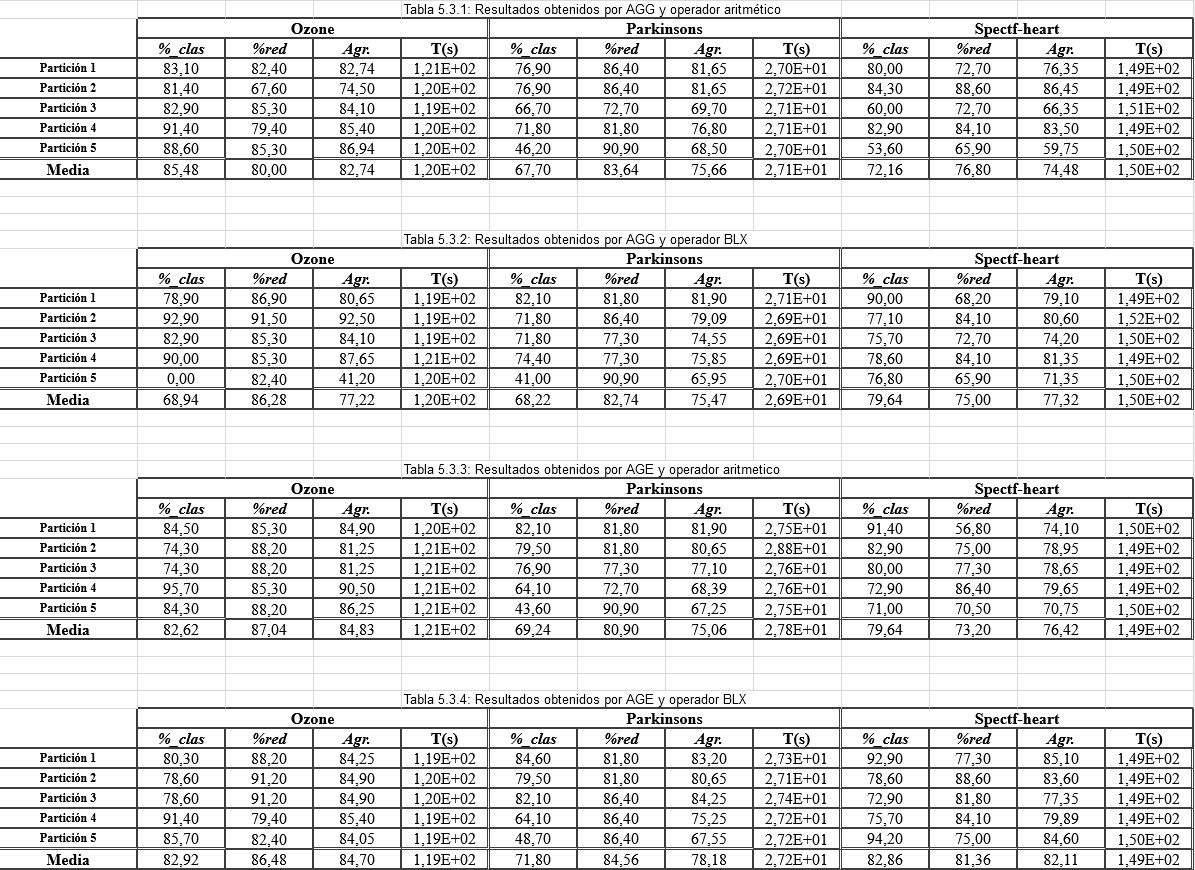

Aquí para los Meméticos:
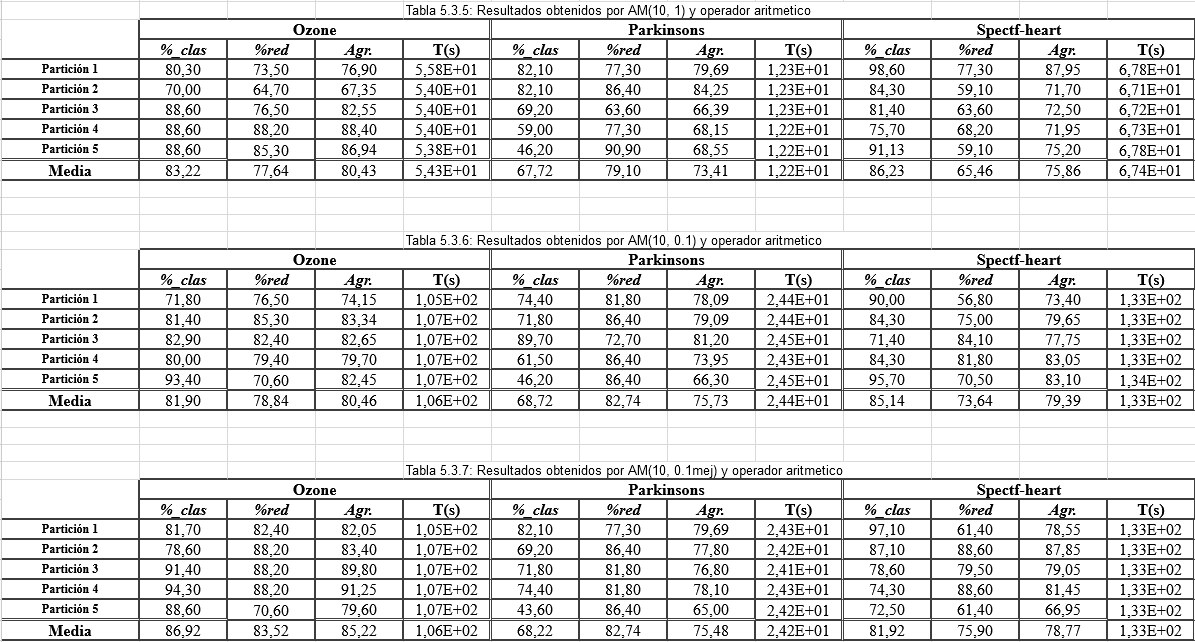

Y la tabla resumen junto a los algoritmos de la práctica 1:
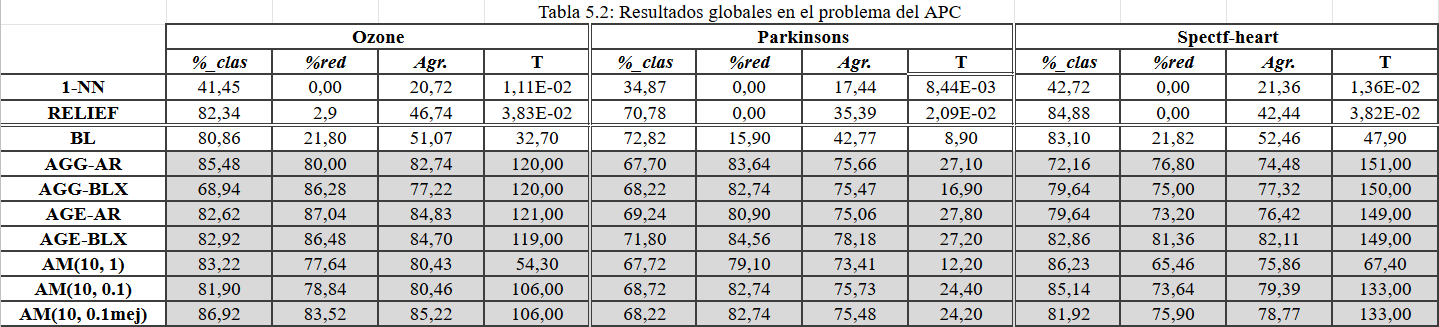

Lo primero que nos llama la atención respecto a los algoritmos de la práctica anterior a parte de que los tiempos son muchísimo mayores, es que obtenemos una tasa de reducción muchísimo mayor, haciendo por tanto que la función de agregación de mejores resultados. Es curioso destacar que para el dataset de parkinsons el porcentaje de clasificación es menor que la búsqueda local en todos los casos. <br>

Comparando el operador aritmético y el BLX para los algoritmos genéticos, el BLX da una mejor agregación en 2 de 3 datasets para AGG y también para AGE, aunque no para los mismos datasets. Podríamos extrapolar de esto que el BLX es un mejor operador de cruce que el aritmético y que sería razonable utilizarlo para los algoritmos meméticos, pero curiosamente se han hecho todas las ejecuciones de meméticos com ambos datasets, y se obtienen mejores resultados con el operador aritmético, por lo que es ese el que se ha incluido en la tabla resumen. El profesor puede comprobar los otros resultados si quiere en la sección de ejecuciones. <br>

Entre el AGE y el AGG, podemos ver que ambos obtienen resultados similares de agregación en la mayoría de los casos, aunque el AGE se situa ligeramente por encima, sobre todo con el cruce BLX, donde vemos que la mejora empieza a ser significativa entre los dos. <br>

En cuanto a los algoritmos meméticos, parece que los que mejores resultados obtienen en agregación son AM(10,0.1) y AM(10,0.1mej). Esto lo podemos achacar a que, al hacer búsqueda local en toda la población, se mejoran todas las soluciones de forma simultanea, acabando con muchas parecidas y por tanto perdiendo con bastante variedad, por lo que podríamos estar perdiendo exploración potencial del espacio de soluciones. Además, al hacer búsqueda local en toda la población, gastamos muchas evaluaciones en soluciones que no tenían mucho futuro, terminando la búsqueda antes y perdiendo así mucha exploración. <br>
 
En cuanto a AM(10,0.1) y AM(10,0.1mej), no parece que haya diferencias significaticas entre seleccionar el mejor para la búsqueda local o uno al azar. Esto quizás se pueda deber a que hay muchas soluciones buenas parecidas en la población, y en la mayoría de los casos no importe mucho explorar en cualquiera de ellas que estén en el top. Aunque en la mayoría de datasets sigue siendo mejor aunque sea por muy poco escoger el mejor, y en concreto en Ozone se consiguen diferencias muy significativas. <br>

A la hora de comparar los algoritmos meméticos con los genéticos, vemos que solo obtenemos una mejora en la agregación en Ozone. Esto en principio puede chocarnos, ya que uno podría pensar que, al seguir el esquema de AGG pero añadiendo una BL que mejora soluciones, nos tendría que dar sí o sí mejores resultados. Pero tenemos que tener en cuenta que los meméticos tienen una población de 10 cromosomas en lugar de los 30 con los que hemos ejecutado los genéticos. Ahí ya estamos perdiendo potencial variedad de la población, y por tanto, exploración del espacio de soluciones. Además, sabemos que la BL no obtiene mucha reducción, por lo que las soluciones que se mejoran con esta en los meméticos tendrán menos reducción que habiéndolas obtenido por el proceso evolutivo. Esto también baja el fitness por supuesto. <br>

En conclusión, los algoritmos meméticos podrían obtener unos resultados sustancialmente mejores si se añadiera mayor variedad de población.
